### Dependencies for this task

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [25]:
# function to verify file pathway is valid
def directory_verification(directory):
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        exit()

# function to verify file is an image
def file_verification(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

### Using a corner detector algorithm to detect aircraft in satellite images of an airport

The objective here is to detect aircraft in an airport using traditional technqiues to do so. This will be done using OpenCV's [ORB](https://docs.opencv.org/4.x/db/d95/classcv_1_1ORB.html#details) algorithm to detect the key features by calculating the key points and descriptors of the features and display the similarites with another image from the dataset. Key points are the points of interest that a human would notice when looking at an image, in our case the key points are the airplanes parked in the airports and descriptors are an array of numbers attributed to the features which are used to describe these features and are used for feature comparison.

First let's understand what we're working with and take a look at the data.

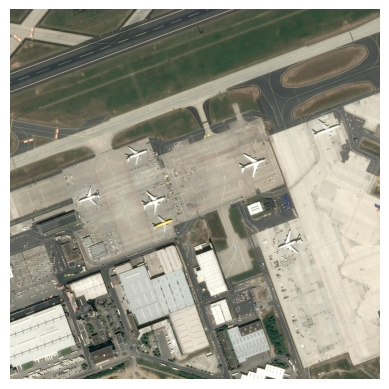

In [26]:
# function to read the images by taking there path
def read_image(path1,path2):
    read_img1 = cv2.imread(path1)
    read_img2 = cv2.imread(path2)
    return (read_img1,read_img2)

# function to display a random image from the dataset
def display_random_image(image_directory):
  random_image = np.random.choice(os.listdir(image_directory))
  image_path = os.path.join(image_directory, random_image)
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

HOME = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection" # change HOME to the directory where the repo was cloned
image_directory = os.path.join(HOME, 'airbus-aircrafts-sample-dataset/images')
display_random_image(image_directory)

Each image is a satellite image of an airport from around the world taken at different times, some images have all the airplanes clearly visible, some have airplanes being obscured by clouds and fog, and some have airplanes that have been cutoff by the image border.

### Prepping the dataset for analysis

The ORB keypoint detector requires the image to be in grayscale as it uses the difference in contrast and intensity between objects in order to detect features in the image, this requires the input data to be converted to grayscale before use. 

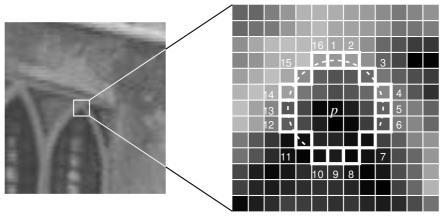

In [27]:
# function to convert images from RGB to gray scale
def transform_image(pic1,pic2):
    gray_img1 = cv2.cvtColor(pic1,cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(pic2,cv2.COLOR_BGR2GRAY)
    return (gray_img1,gray_img2)

### Finding the keypoints

ORB uses a combination of algorithms: [FAST](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html) algorithm which uses differences in intensity and contrast in the image to find the top N number(s) of key points using Harries corner measure, and [BRIEF](https://docs.opencv.org/4.x/dc/d7d/tutorial_py_brief.html) algorithm which takes the key points found and converts them into a binary descriptor for use in image feature comparison.

In [28]:
# function to detect the features by finding key points
# and descriptors from the image
def detector(image1,image2):
    # creating ORB detector
    detect = cv2.ORB_create()

    # finding key points and descriptors of both images
    # using detectAndCompute() function
    key_point1,descrip1 = detect.detectAndCompute(image1,None)
    key_point2,descrip2 = detect.detectAndCompute(image2,None)
    return (key_point1,descrip1,key_point2,descrip2)

### Calculating the descriptors of the features

To find the common features from two images, we will be using OpenCV's Brute Force matcher, which takes the descriptors of the features found by the ORB algorithm in the first set and matches them with all the features found in the second set by calculating the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between features and matching features with similar distances.

In [29]:
# function to find best detected features using brute
# force matcher and match them according to their humming distance
def BF_FeatureMatcher(des1,des2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    no_of_matches = brute_force.match(des1,des2)

    # finding the humming distance of the matches and sorting them
    no_of_matches = sorted(no_of_matches,key=lambda x: x.distance)
    return no_of_matches

### Determine the number of matching features
Now that the key points and descriptors have been calculated, we can draw the matching features onto the images and compare them

In [37]:
# function to process the image using the ORB algorithm and apply the brute force feature matcher
def use_algorithm(gray_pic1, gray_pic2, filename):
    key_pt1, descrip1, key_pt2, descrip2 = detector(gray_pic1, gray_pic2) # finds the key points and descriptors
    number_of_matches = BF_FeatureMatcher(descrip1, descrip2) # finds the total number of matches
    tot_feature_matches = len(number_of_matches)
    print(f'Total Number of Features matches found are {tot_feature_matches}')

    results = cv2.drawMatches(gray_pic1, key_pt1, gray_pic2, key_pt2, number_of_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14, 8))
    plt.imshow(results, cmap="gray")
    plt.title("Feature Matching Using ORB")
    plt.axis("off")
    os.makedirs("processed images", exist_ok=True)
    plt.savefig(f"processed images/processed-{filename}")
    plt.close(fig=None)
    return results

In [ ]:
# comparing each image in the image directory to a template image
image_template = os.path.join(HOME, 'py/Question 1/airplane_template.jpg')

directory_verification(image_directory) # function to verify directory input is valid

for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)
    if file_verification(filename):
        image1, image2 = read_image(file_path, image_template) # calling the image reading function to read the image data for use
        gray_pic1, gray_pic2 = transform_image(image1, image2) # calling the transform function to change to grayscale
        use_algorithm(gray_pic1, gray_pic2, filename)

Total Number of Features matches found are 52
Total Number of Features matches found are 50
Total Number of Features matches found are 48
Total Number of Features matches found are 46
Total Number of Features matches found are 61
Total Number of Features matches found are 50
Total Number of Features matches found are 45
Total Number of Features matches found are 59
Total Number of Features matches found are 43
Total Number of Features matches found are 50


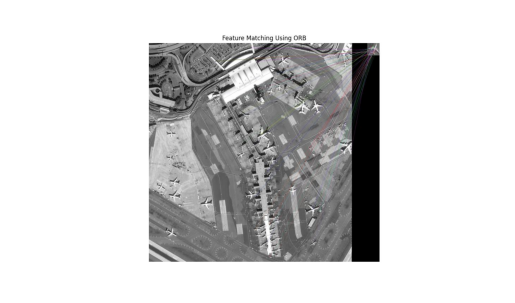

In [36]:
processed_image_directory = os.path.join(HOME, 'py/Question 1/processed images')
display_random_image(processed_image_directory)

The ORB algorithm was chosen for this task as it is a static feature being searched for in the dataset, and ORB is the fastest approach of traditional feature matching avaliable that can handle in-plane rotation of features, this has made it a good choice for finding aircraft which can be facing any direction. 

However the ORB algorithm will search for all the similarites within the two images, including features beyond just the desired airplanes such as crates and runways, this can be minimized by creating a template image containing only the desired features features to be found, but doing this reduces the number the number of features detected to only those that look exactly like the template, filtering features such as truncated aircraft cut off by the image borders and aircraft that have been obscured by fog and clouds.

In [ ]:
# Code was adapted from the following sources:
# https://www.geeksforgeeks.org/feature-matching-using-brute-force-in-opencv/
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# ChatGPT